# Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning
#### Written and Coded by: Joshua Ko
#### Last updated: 11/30/2023
___

This notebook serves to find the best model that will yield the best metrics in predicting patients who have pneumonia, as well as whether the infection is bacterial or viral. The best model can then be stored in a separate file for future use. Unfortunately, image classification is very demanding; these codes were run on a HP Spectre x360 with an i7-10510U CPU. A more accurate model may be found by using better specs and performing a grid search to find optimal hyperparameters.

___
Import some of the necessary libraries

In [1]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

## Unbalanced vs. balanced datasets
When observing the file holding the training images, there is a large imbalance between the `NORMAL` and `PNEUMONIA` class. It is important to balance these classes so that our model is not biased towards one class. In order to balance the dataset, we can scrape more images, or create more images using image augmentation (we will go with the image augmentation approach). However, just running the image through `.ImageDataGenerator()` doesn't store the augmented image. We can create a separate folder of images that stores the augmented images as well as the original, thereby increasing our minority class (in this case, our `NORMAL` class). We can create a balanced dataframe contain the paths of the images (both original and augmented). Then import those images by using `flow_from_dataframe`.

In [2]:
import pandas as pd
import shutil # high-level operation on a file like a copy, create, and remote operation on the file
from tqdm import tqdm # progress bar for loops and iterations

The following functions were provided by [Gerry P](https://stackoverflow.com/users/10798917/gerry-p) from this [stackflow question](https://stackoverflow.com/questions/73971025/how-to-do-data-augmentation-and-save-it-to-another-folder).

In [3]:
def make_dataframe(sdir):
    # sdir is the directory when the class subdirectories are stored
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath))
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    # return a dataframe with columns filepaths, labels
    return df

def make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg'):
    # augdir is the full path where augmented images will be stored
    # n is the number of augmented images that will be created for each class that has less than n image samples
    # img_size is a tupple(height,width) that specifies the size of the augmented images
    # color_mode is 'rgb by default'
    # save_prefix is the prefix augmented images are identified with by default it is 'aug-'
    # save_format is the format augmented images will be save in, by default it is 'jpg'
    # see documentation of ImageDataGenerator at https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for details
    df=df.copy()
    if os.path.isdir(augdir):# start with an empty directory
        shutil.rmtree(augdir)
    os.mkdir(augdir)  # if directory does not exist create it
    for label in df['labels'].unique():
        classpath=os.path.join(augdir,label)
        os.mkdir(classpath) # make class directories within aug directory
    # create and store the augmented images
    total=0
    # in ImageDateGenerator select the types of augmentation you desire below are some examples
    gen=image.ImageDataGenerator(horizontal_flip=True,
                                 rotation_range=20,
                                 width_shift_range=.1,
                                 height_shift_range=.1)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        classdir=os.path.join(augdir, label)
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=classdir, save_prefix=save_prefix, color_mode=color_mode,
                                            save_format=save_format, seed=42)
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)

In [4]:
# run the make_dataframe() function on the train set to see how many images to augment
train_directory = 'Data/chest_xray/train/'
df = make_dataframe(train_directory)

print(
    df.head(), # inspect the dataframe so that it is properly integrated into the dataframe
    '\nlength of dataframe is ',len(df)
)

PNEUMONIA                : 100%|███████████████████████████████████████████████████████| 3883/3883 [00:00<00:00, 352895.55files/s]

                                           filepaths  labels
0  Data/chest_xray/train/NORMAL\NORMAL-1003233-00...  NORMAL
1  Data/chest_xray/train/NORMAL\NORMAL-1012843-00...  NORMAL
2  Data/chest_xray/train/NORMAL\NORMAL-1014768-00...  NORMAL
3  Data/chest_xray/train/NORMAL\NORMAL-1023731-00...  NORMAL
4  Data/chest_xray/train/NORMAL\NORMAL-1029510-00...  NORMAL 
length of dataframe is  5232


Seems like there are 2534 more images labeled `PNEUMONIA`; we must augment that many `NORMAL` images to balance the classes. However over augmenting the images may lead to overfitting, therefore we will augment the minority class until we reach a total of `2500` `NORMAL` images and undersample the majority.

In [5]:
augment_dir='Data\Augmented' # A newly created folder titled `Augmented` holds the augmented image.

make_and_store_images(df, augment_dir, n=2500, img_size=(256,256), color_mode='rgb', save_prefix='aug-',save_format='jpg')

Found 1349 validated image filenames.    for class             NORMAL             creating 1151  augmented images 
Total Augmented images created=  1151


In [6]:
aug_df = make_dataframe(augment_dir) # using the same function to create a dataframe with labels and file paths
len(aug_df) # check to see if all the images are stored in the dataframe

NORMAL                   : 100%|███████████████████████████████████████████████████████| 1151/1151 [00:00<00:00, 383542.06files/s]
PNEUMONIA                : 0files [00:00, ?files/s]


1151

An undersampled dataframe will store `2500` filepaths of the majority class. Then `df` will be concatenated with rows only containing the `NORMAL` class along with `aug_df`.

In [7]:
# undersampling the number of images labeled 'pneumonia'
under_df = df[df['filepaths'].str.contains('PNEUMONIA')].sample(n=2500, random_state=42, ignore_index=False)

print(
    under_df.head(),
    '\n',
    under_df['labels'].value_counts()
)

                                              filepaths     labels
2693  Data/chest_xray/train/PNEUMONIA\BACTERIA-56283...  PNEUMONIA
3986  Data/chest_xray/train/PNEUMONIA\VIRUS-1623574-...  PNEUMONIA
4947  Data/chest_xray/train/PNEUMONIA\VIRUS-8054264-...  PNEUMONIA
4964  Data/chest_xray/train/PNEUMONIA\VIRUS-8161653-...  PNEUMONIA
3161  Data/chest_xray/train/PNEUMONIA\BACTERIA-74378...  PNEUMONIA 
 labels
PNEUMONIA    2500
Name: count, dtype: int64


In [8]:
# concatenate the dataframes
balanced_df = pd.concat([under_df, df[df['filepaths'].str.contains('NORMAL')], aug_df], ignore_index=True)
balanced_df['labels'].value_counts() # check to see if classes are balanced

labels
PNEUMONIA    2500
NORMAL       2500
Name: count, dtype: int64

Upon further inspection of the dataframe, the features of the dataframe are organized according to its labels (`NORMAL` or `PNEUMONIA`). Although this may not affect the `train_generator` as `shuffle=True`, this may cause the validation set to be highly biased towards one class. Therefore we will shuffle the dataframe.

In [9]:
from sklearn.utils import shuffle

balanced_df = shuffle(balanced_df, random_state=42)

## Importing images from dataframe
Now that the classes are balanced, we can import the images using `.flow_froma_dataframe`. To import, batch, and standardize the images, the class, `ImageDataGenerator()` is used. To check that the images are properly imported, we can use matplotlib's `.imshow()`.
<br>
<br>First, we will define the target and batch size:

In [10]:
target_size = (256, 256) # a larger targe_size can be used if the computer has the specs for it
batch_size = 32 # a batch_size of 128 or more will need a high performing GPU

In [11]:
train_datagen = image.ImageDataGenerator(rescale=1./255, # standardizes color pixels that have a maximum value of 255
                                         validation_split=0.2 # allocates 20% of the data as the validation set
                                        )

In [12]:
# import the balanced imageset from balanced_df using .flow_from_dataframe()
balanced_train_generator = train_datagen.flow_from_dataframe(
    balanced_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

balanced_validation_generator = train_datagen.flow_from_dataframe(
    balanced_df,
    x_col='filepaths',
    y_col='labels',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


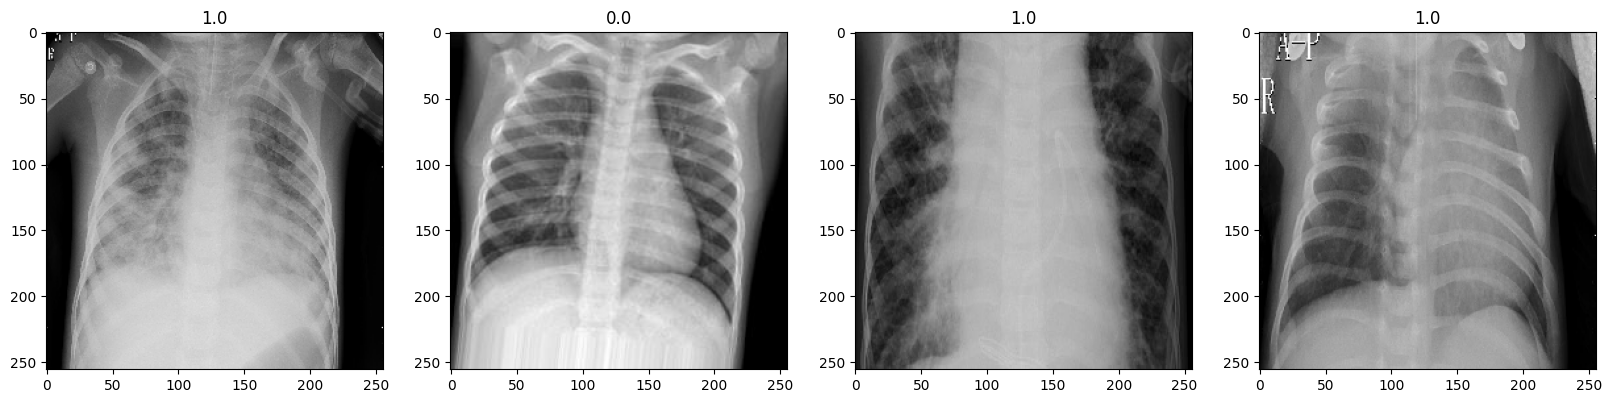

In [13]:
# check if the images are properly imported
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(balanced_train_generator[0][0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(balanced_train_generator[0][1][idx])

According to the images shown, `NORMAL` = `0` and `PNEUMONIA` = `1`.

## Creating the neural network

We will be making a `Sequential()` model to help us differentiate between the two classes. In order to determine the complexity of the neural network, we should start with a simple model and integrate more layers according to the metrics of the model.  We can observe the metrics of each epoch by importing from `keras.metrics`.

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.metrics import MeanSquaredError, TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, BinaryAccuracy, AUC

In [15]:
# metrics used to observe the improvement or lack there of per epoch
metrics = [
    'acc',
    MeanSquaredError(name='Brier score'),
    TruePositives(name='tp'),
    FalsePositives(name='fp'),
    TrueNegatives(name='tn'),
    FalseNegatives(name='fn'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    AUC(name='prc', curve='PR') # precision-recall curve
]

A simple neural network with one hidden layer will be constructed and tested first, as a more complex network may lead to overfitting. If the metrics are too poor, we can add different layers to the network.

In [16]:
# fitting the balanced dataset
simple_model = Sequential()

simple_model.add(Flatten(input_shape=(256,256,3)))
# input layer that flattens the images into a 1-D array

simple_model.add(Dense(64, activation='relu'))
# A hidden layer with 64 nodes

simple_model.add(Dense(1, activation='sigmoid'))
# Output layer yielding only 1 value

simple_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)

balanced_history = simple_model.fit(balanced_train_generator,
          steps_per_epoch=int(np.ceil(4000/batch_size)),
          epochs=30,
          validation_data=balanced_validation_generator,
          validation_steps=int(np.ceil(1000/batch_size)))

Epoch 1/30
125/125 [==============================] - 37s 286ms/step - loss: 6.8372 - acc: 0.5058 - Brier score: 0.3028 - tp: 1673.0000 - fp: 1650.0000 - tn: 350.0000 - fn: 327.0000 - precision: 0.5035 - recall: 0.8365 - auc: 0.5036 - prc: 0.5020 - val_loss: 0.6932 - val_acc: 0.5000 - val_Brier score: 0.2500 - val_tp: 500.0000 - val_fp: 500.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 2/30
125/125 [==============================] - 31s 245ms/step - loss: 0.6932 - acc: 0.5000 - Brier score: 0.2500 - tp: 2000.0000 - fp: 2000.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - precision: 0.5000 - recall: 1.0000 - auc: 0.5000 - prc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000 - val_Brier score: 0.2500 - val_tp: 500.0000 - val_fp: 500.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.5000
Epoch 3/30
125/125 [==============================] - 

The simple neural network performed decently on the training set. However, the validation metrics are very inconsistent.
<br>It also seems like the model may not learn in certain run throughs. For example, the accuracy, or `acc`, may remain stagnant at `0.500`. We can maybe prevent this and improve the model by adding a convolutional layer.
<br>
<br>This can be a long process. We can maximize our productivity by implementing `EarlyStopping()`. This will allow the model to stop learning by monitoring a specific metric (accuracy, mse, loss, etc). This will help prevent overfitting.

In [17]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='auto', restore_best_weights=False)
# restore_best_weights can be set to true if you wish to store each model. This can be costly in terms of memory

In [18]:
# balanced dataset fitted in a cnn
cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(256,256,3)))
cnn_model.add(MaxPooling2D(2,2))
# Conv2D is a 2-D filter that slides through the matrix and multiplies the corresponding values
# MaxPooling2D strides through the newly created matrix and takes the maximum value within a 2x2 range

cnn_model.add(Flatten())

cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)


cnn_history = cnn_model.fit(balanced_train_generator,
          steps_per_epoch=int(np.ceil(4000/batch_size)),
          epochs=30,
          validation_data=balanced_validation_generator,
          validation_steps=int(np.ceil(1000/batch_size)),
          callbacks=[early_stop])

Epoch 1/30
125/125 [==============================] - 40s 266ms/step - loss: 1.6735 - acc: 0.8315 - Brier score: 0.1635 - tp: 2087.0000 - fp: 761.0000 - tn: 1739.0000 - fn: 413.0000 - precision: 0.7328 - recall: 0.8348 - auc: 0.8341 - prc: 0.8241 - val_loss: 0.1391 - val_acc: 0.9490 - val_Brier score: 0.0372 - val_tp: 478.0000 - val_fp: 29.0000 - val_tn: 471.0000 - val_fn: 22.0000 - val_precision: 0.9428 - val_recall: 0.9560 - val_auc: 0.9891 - val_prc: 0.9914
Epoch 2/30
125/125 [==============================] - 33s 260ms/step - loss: 0.0981 - acc: 0.9647 - Brier score: 0.0257 - tp: 1907.0000 - fp: 48.0000 - tn: 1952.0000 - fn: 93.0000 - precision: 0.9754 - recall: 0.9535 - auc: 0.9939 - prc: 0.9946 - val_loss: 0.1844 - val_acc: 0.9360 - val_Brier score: 0.0516 - val_tp: 496.0000 - val_fp: 60.0000 - val_tn: 440.0000 - val_fn: 4.0000 - val_precision: 0.8921 - val_recall: 0.9920 - val_auc: 0.9905 - val_prc: 0.9910
Epoch 3/30
125/125 [==============================] - 33s 261ms/step - lo

It performed significantly better than the simple. We will observe how well the `cnn_model` performed by plotting the changes of the metrics as the epoch progresses.

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# a list of different colors to help discern between metrics of two models

def plot_metrics(history_1, history_2, legend1='Unbalanced Train', legend2='Unbalanced Val', legend3='Balanced Train', legend4='Balanced Val'):
    # history_1 and history_2 are the two different histories that will be compared

    fig, axs = plt.subplots(3,2, figsize=(15, 10), dpi=100)
    axs = axs.ravel()
    # enumerates the axes going from left to right across the rows from the top row down to the bottom row

    metrics = ['acc','loss', 'auc', 'prc', 'precision', 'recall']
    # list of metrics so we can easily observe the changes

    for n, metric in enumerate(metrics): # loops through list
        name = metric.capitalize()
        # capitalizes the strings in the list (metrics) so we can use it to title the graphs

        axs[n].plot(history_1.epoch, history_1.history[metric], color=colors[0], label=legend1)
        axs[n].plot(history_1.epoch, history_1.history['val_'+metric], color=colors[0], linestyle='--', label=legend2)
        # creates a plot for the corresponding metric with a separate color to help discern from the balanced_history
        # the linestyle will help separate the validation metric with the train metric

        axs[n].plot(history_2.epoch, history_2.history[metric], color=colors[1], label=legend3)
        axs[n].plot(history_2.epoch, history_2.history['val_'+metric], color=colors[1], linestyle='--', label=legend4)

        axs[n].set_xlabel('Epoch')
        axs[n].set_ylabel(name)
        axs[n].set_title('Training and validation {}'.format(metric))

        if metric == 'loss':
            axs[n].legend(loc='upper right')
            axs[n].set_ylim(0, 1.0)
        # since the 'loss' in earlier epochs is huge, we can limit the y axis so we can observe smaller changes

        else:
            axs[n].legend(loc='lower right')

    plt.tight_layout()

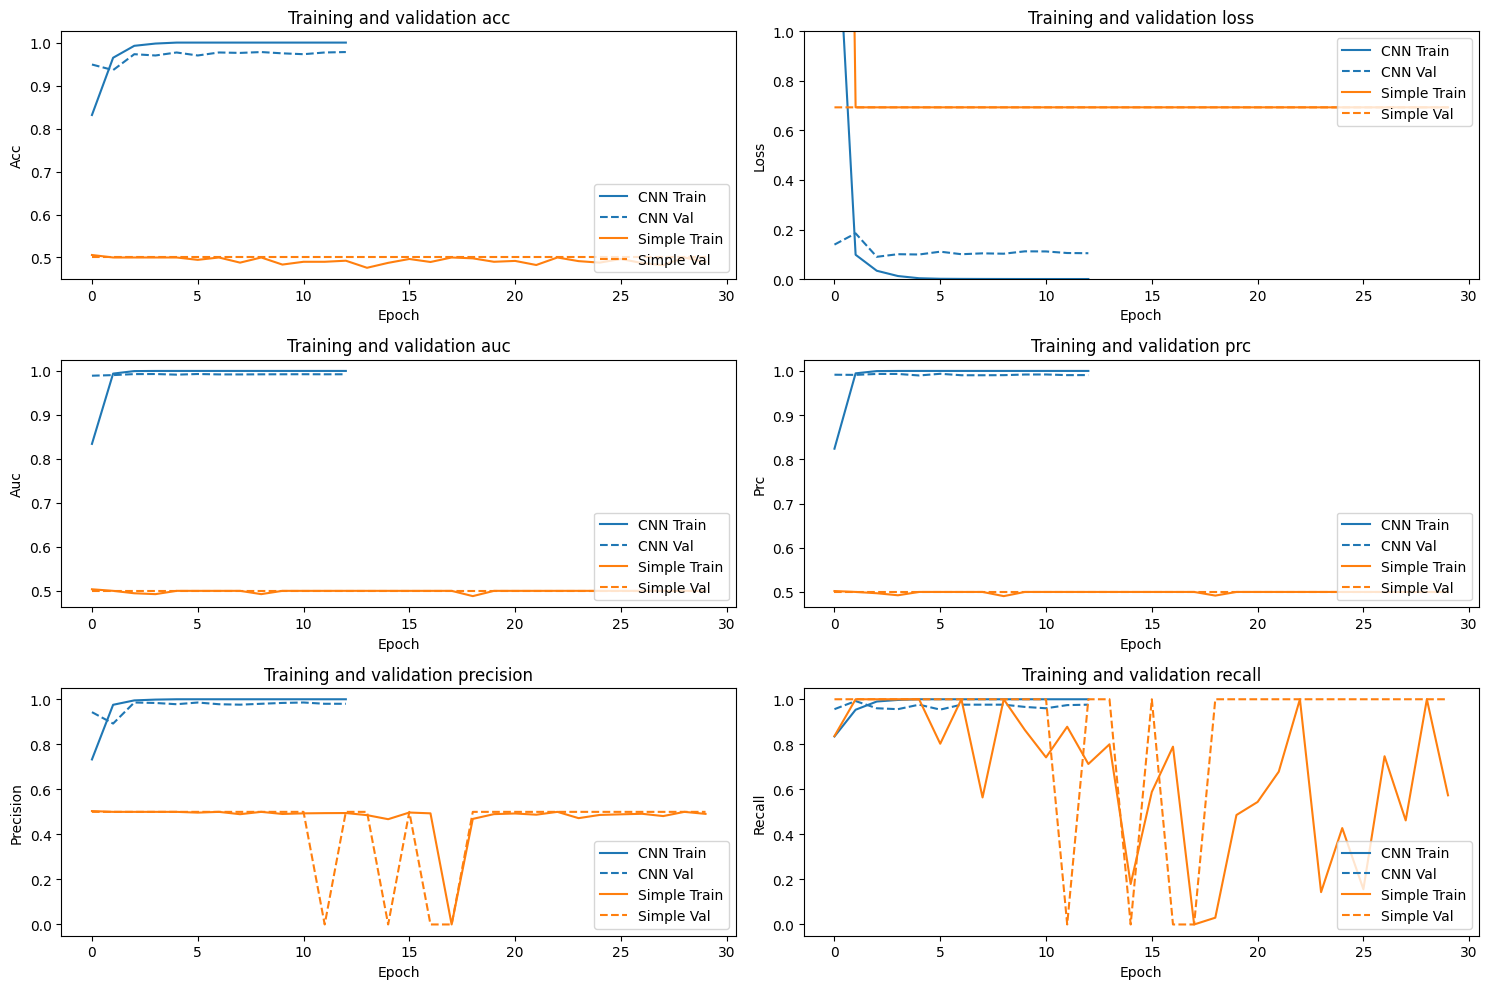

In [20]:
# we are comparing the result of the addition of the convolutional layer and the simple model
plot_metrics(cnn_history, balanced_history, legend1='CNN Train', legend2='CNN Val', legend3='Simple Train', legend4='Simple Val')

Adding the convolutional layer dramatically improved the model, despite a slight overfitting for the balanced dataset. The plots also seem to plateau with higher epoch, therefore a higher epoch most likely would not alter the metrics between the train and validation sets. However, the metrics are relatively high (above 90%) and we can run the test set and create our predictions.

## Preparing the test imageset and making predictions
Again, we can use `.ImageDataGenerator()` to import our test set from the directory we defined above (`test_directory`). We will run the test set through `cnn_model` and observe the performance by observing the confusion matrix.

In [21]:
# importing the test imageset
test_directory = 'Data/chest_xray/test/'

test_datagen = image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [22]:
assert test_generator[0][0].shape == (32, 256, 256, 3) # check if the test set is properly imported

In [23]:
def predict(test_generator, model):
# test_generator holds the images imported from the directory
# model is the model we are running the test images through to make our prediction

    y_hat = model.predict(test_generator, batch_size=batch_size, steps=len(test_generator))
    # the y_hat is a 1-D array with decimals
    y_hat = list(np.rint(y_hat.reshape(624,)))
    # rounds the y_hat to its nearest integer and converts the array to a list
    return y_hat

In [24]:
# make predictions by running the function with proper inputs
y_hat = predict(test_generator, cnn_model)

20/20 [==============================] - 5s 244ms/step


Once the predictions are stored, we can plot a confusion matrix to see how well the models performs. Before feeding the test labels and predictions into `confusion_matrix()`, the labels in the test set needs to be combined into one list or array, instead of batches.

In [25]:
# converting the labels to a list so we can run it through confusion_matrix()
test_labels = []

for x in range(0, len(test_generator)):
    test_labels.extend(np.array(test_generator[x][1]))

print('0 occurences: ', test_labels.count(0))
print('1 occurences: ', test_labels.count(1))

0 occurences:  234
1 occurences:  390


There are `390` patients who have pneumonia and `234` who do not.

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def cf_matrix(y_hat):
#y_hat is the predictions we have made using the predict() function
    cm = confusion_matrix(test_labels, y_hat)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

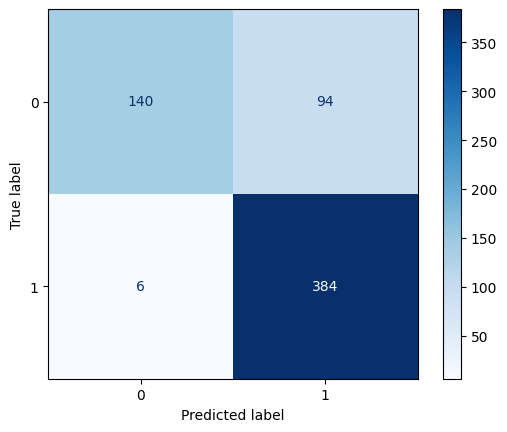

In [27]:
#confusion matrix of values predicted by the convolutional layer
cf_matrix(y_hat)

We can also use the metrics from `sklearn.metrics` to calculate our scores:

In [28]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def print_metrics(y_test, y_hat):
    print("Precision Score: {}".format(precision_score(y_test, y_hat)))
    print("Recall Score: {}".format(recall_score(y_test, y_hat)))
    print("Accuracy Score: {}".format(accuracy_score(y_test, y_hat)))
    print("F1 Score: {}".format(f1_score(y_test, y_hat)))

In [29]:
# unbalanced metrics
print_metrics(test_labels, y_hat)

Precision Score: 0.803347280334728
Recall Score: 0.9846153846153847
Accuracy Score: 0.8397435897435898
F1 Score: 0.8847926267281107


The precision and accuracy leaves a lot to be desired. However, the recall score is high meaning that the model does a good job minimizing the false negative. This is a preferred metric over precision because a model with a high false negative will be harmful to both the patient and the hospital. Results may vary as these codes are repeatedly run, but should not vary too far from these values. We can address the overfitting of the model by incorporated some form of regression. While adding these changes to the model, we will monitor how the recall and accuracy scores change; preferably a relatively high recall and accuracy score while minimizing the overfitting.

### Performing a ridge regression
By performing a regression, we can fix the overfitting of the convolutional model. The ridge regression or l2 regularizer can be imported from `tensorflow.keras.regularizers` (a lasso regression or l1 regularizer can also be used).

In [30]:
from tensorflow.keras import regularizers

In [31]:
l2_model = Sequential()

l2_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(256,256,3)))
l2_model.add(MaxPooling2D(2,2))

l2_model.add(Flatten())

l2_model.add(Dense(64, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))
# the value for regularizers.l2() can range from 0 to infinity
l2_model.add(Dense(1, activation='sigmoid'))

l2_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)

l2_history = l2_model.fit(balanced_train_generator,
          steps_per_epoch=int(np.ceil(4000/batch_size)),
          epochs=30,
          validation_data=balanced_validation_generator,
          validation_steps=int(np.ceil(1000/batch_size)),
          callbacks=[early_stop])

Epoch 1/30
125/125 [==============================] - 32s 248ms/step - loss: 3.1454 - acc: 0.8198 - Brier score: 0.1295 - tp: 2082.0000 - fp: 325.0000 - tn: 2175.0000 - fn: 418.0000 - precision: 0.8650 - recall: 0.8328 - auc: 0.8690 - prc: 0.8300 - val_loss: 0.5168 - val_acc: 0.8890 - val_Brier score: 0.0862 - val_tp: 492.0000 - val_fp: 103.0000 - val_tn: 397.0000 - val_fn: 8.0000 - val_precision: 0.8269 - val_recall: 0.9840 - val_auc: 0.9846 - val_prc: 0.9858
Epoch 2/30
125/125 [==============================] - 31s 243ms/step - loss: 0.3699 - acc: 0.9420 - Brier score: 0.0489 - tp: 1853.0000 - fp: 85.0000 - tn: 1915.0000 - fn: 147.0000 - precision: 0.9561 - recall: 0.9265 - auc: 0.9843 - prc: 0.9864 - val_loss: 0.2965 - val_acc: 0.9570 - val_Brier score: 0.0363 - val_tp: 469.0000 - val_fp: 12.0000 - val_tn: 488.0000 - val_fn: 31.0000 - val_precision: 0.9751 - val_recall: 0.9380 - val_auc: 0.9925 - val_prc: 0.9928
Epoch 3/30
125/125 [==============================] - 31s 244ms/step - 

Epoch 19/30
125/125 [==============================] - 31s 242ms/step - loss: 0.1196 - acc: 0.9822 - Brier score: 0.0155 - tp: 1960.0000 - fp: 31.0000 - tn: 1969.0000 - fn: 40.0000 - precision: 0.9844 - recall: 0.9800 - auc: 0.9984 - prc: 0.9985 - val_loss: 0.1559 - val_acc: 0.9680 - val_Brier score: 0.0260 - val_tp: 484.0000 - val_fp: 16.0000 - val_tn: 484.0000 - val_fn: 16.0000 - val_precision: 0.9680 - val_recall: 0.9680 - val_auc: 0.9932 - val_prc: 0.9920
Epoch 20/30
125/125 [==============================] - 31s 244ms/step - loss: 0.1109 - acc: 0.9858 - Brier score: 0.0125 - tp: 1961.0000 - fp: 18.0000 - tn: 1982.0000 - fn: 39.0000 - precision: 0.9909 - recall: 0.9805 - auc: 0.9987 - prc: 0.9989 - val_loss: 0.1337 - val_acc: 0.9750 - val_Brier score: 0.0209 - val_tp: 491.0000 - val_fp: 16.0000 - val_tn: 484.0000 - val_fn: 9.0000 - val_precision: 0.9684 - val_recall: 0.9820 - val_auc: 0.9964 - val_prc: 0.9964
Epoch 21/30
125/125 [==============================] - 30s 243ms/step - l

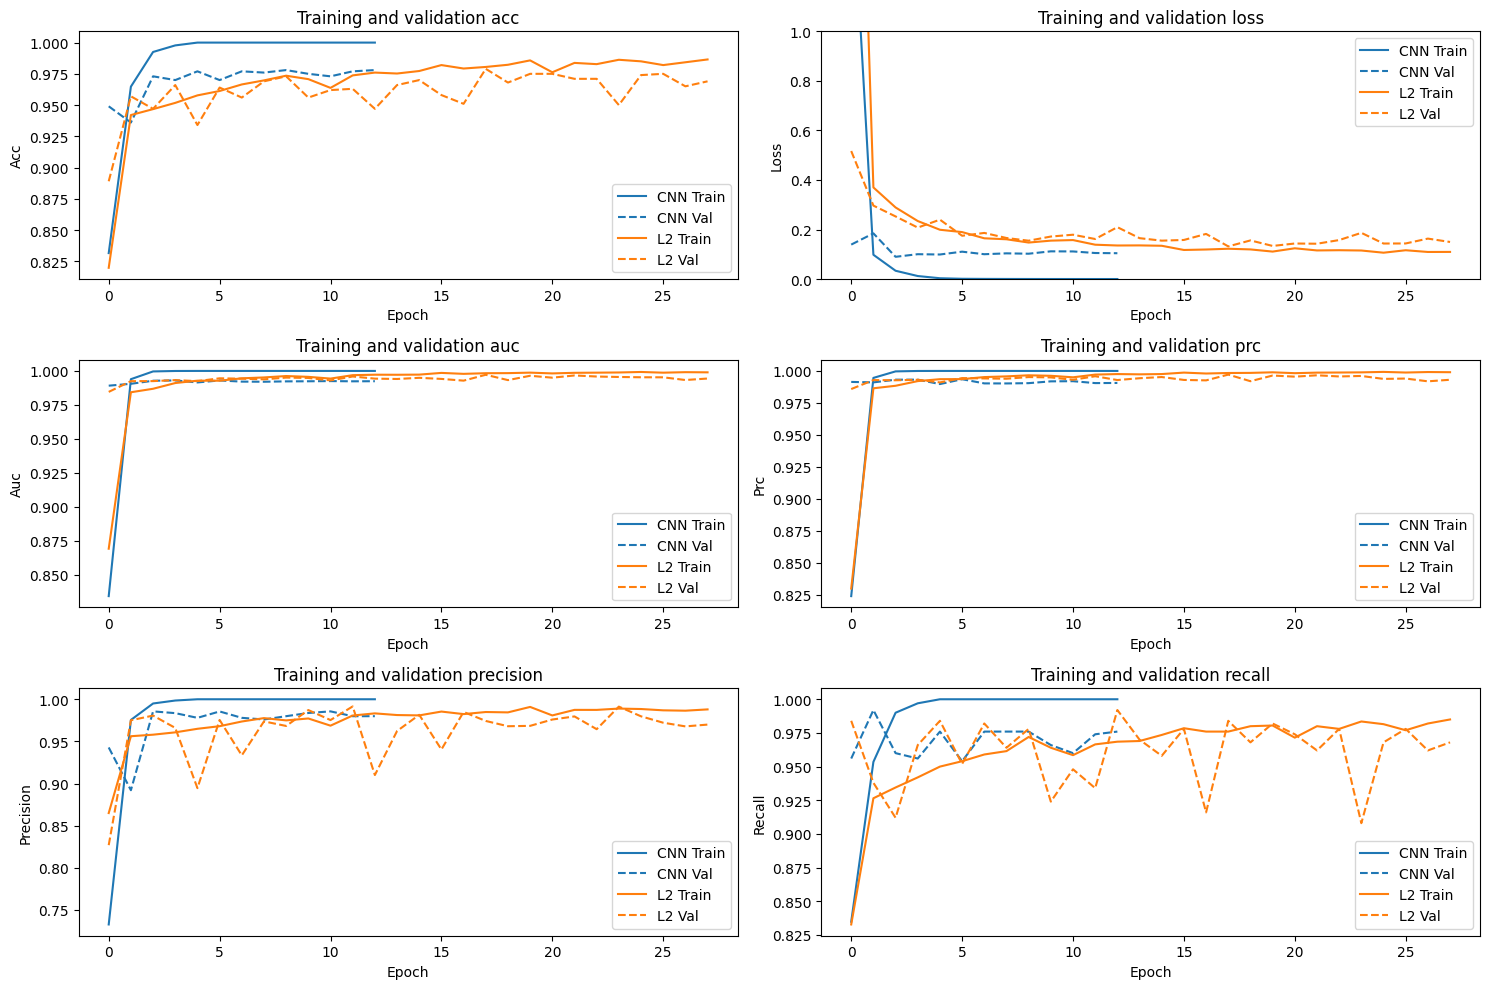

In [32]:
plot_metrics(cnn_history, l2_history, legend1='CNN Train', legend2='CNN Val', legend3='L2 Train', legend4='L2 Val')

The addition of l2 regularizer did lower the overfitting but at the cost of `loss`, `precision`, and `acc`. Perhaps increasing the epoch and allowing the model to learn will fix the volatility of the metrics.
<br>
<br>Regardless, we will obtain the confusion matrix and scores of the new model:

In [33]:
l2_y_hat = predict(test_generator, l2_model)

20/20 [==============================] - 5s 220ms/step


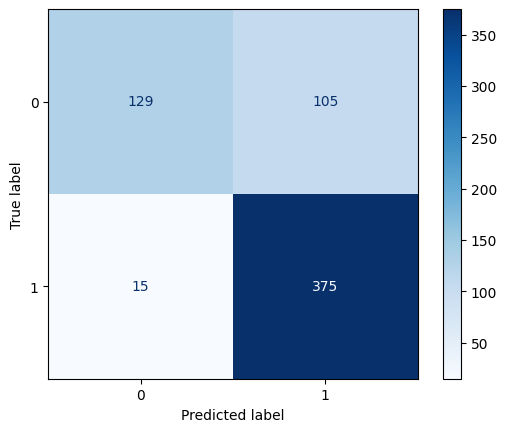

In [34]:
cf_matrix(l2_y_hat)

In [35]:
print_metrics(test_labels, l2_y_hat)

Precision Score: 0.78125
Recall Score: 0.9615384615384616
Accuracy Score: 0.8076923076923077
F1 Score: 0.8620689655172413


Adding a ridge regression did reduce overfitting but with a major cost to both precision and accuracy of the model. To determine the best lambda value for the ridge regression, we can input a list of lambda values for `regularizer.l2()`, and create a `GridSearchCV` with a `param_grid` containing the list of lambda values. However, the computational power needed exceeds my current resources.

### Adding a dropout layer to combat overfitting
Another way to lower overfitting is by adding a `Dropout()` layer. This layer drops some of the nodes within the neural network before moving to the next. The best float value for the dropout layer can be found the same way as the lambda value for ridge regression.

In [36]:
from keras.layers import Dropout

In [37]:
dropout_model = Sequential()

dropout_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(256,256,3)))
dropout_model.add(MaxPooling2D(2,2))

dropout_model.add(Flatten())

dropout_model.add(Dense(64, activation='relu'))
dropout_model.add(Dropout(0.3))
# added dropout layer with a 30% drop rate
dropout_model.add(Dense(1, activation='sigmoid'))

dropout_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)


dropout_history = dropout_model.fit(balanced_train_generator,
          steps_per_epoch=int(np.ceil(4000/batch_size)),
          epochs=30,
          validation_data=balanced_validation_generator,
          validation_steps=int(np.ceil(1000/batch_size)),
          callbacks=[early_stop])

Epoch 1/30
125/125 [==============================] - 32s 249ms/step - loss: 1.2298 - acc: 0.7588 - Brier score: 0.1482 - tp: 1878.0000 - fp: 374.0000 - tn: 2126.0000 - fn: 622.0000 - precision: 0.8339 - recall: 0.7512 - auc: 0.8653 - prc: 0.8450 - val_loss: 0.2054 - val_acc: 0.9380 - val_Brier score: 0.0536 - val_tp: 470.0000 - val_fp: 32.0000 - val_tn: 468.0000 - val_fn: 30.0000 - val_precision: 0.9363 - val_recall: 0.9400 - val_auc: 0.9870 - val_prc: 0.9882
Epoch 2/30
125/125 [==============================] - 31s 245ms/step - loss: 0.2705 - acc: 0.8992 - Brier score: 0.0812 - tp: 1758.0000 - fp: 161.0000 - tn: 1839.0000 - fn: 242.0000 - precision: 0.9161 - recall: 0.8790 - auc: 0.9597 - prc: 0.9648 - val_loss: 0.1529 - val_acc: 0.9460 - val_Brier score: 0.0406 - val_tp: 453.0000 - val_fp: 7.0000 - val_tn: 493.0000 - val_fn: 47.0000 - val_precision: 0.9848 - val_recall: 0.9060 - val_auc: 0.9913 - val_prc: 0.9918
Epoch 3/30
125/125 [==============================] - 30s 243ms/step - 

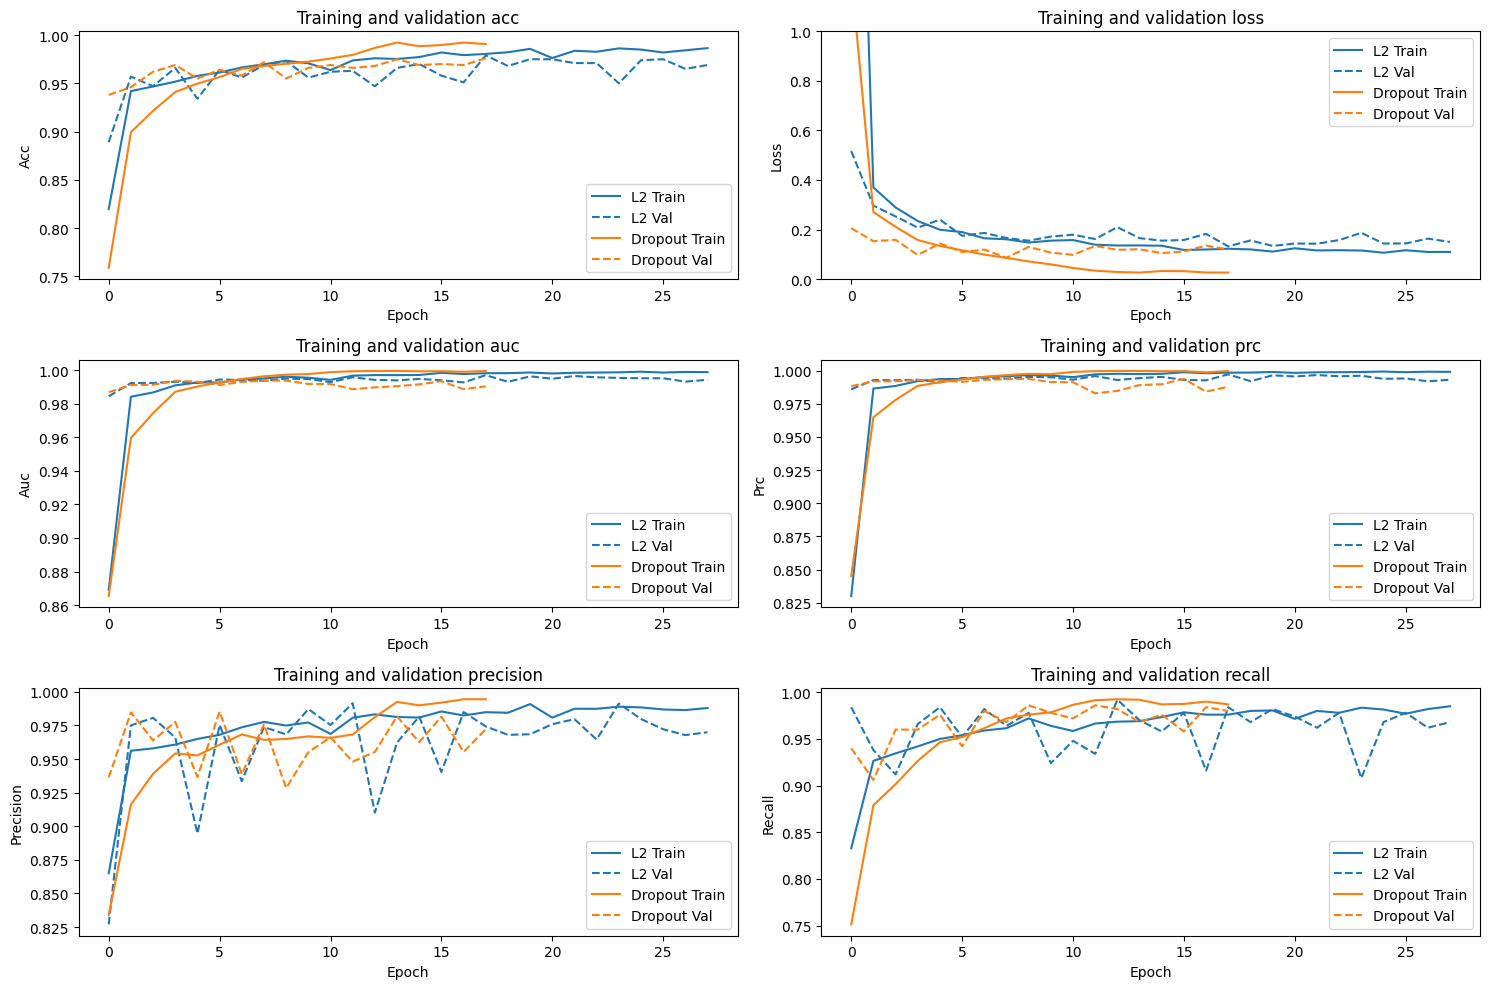

In [38]:
plot_metrics(l2_history, dropout_history, legend1='L2 Train', legend2='L2 Val', legend3='Dropout Train', legend4='Dropout Val')

Using a dropout layer instead of ridge regression yielded more overfitting, therefore we will integrate the ridge regression to future models.

## More layers
Adding more layers allows the model to learn more complex tasks. If the data has greater complexity and dimensionality, multiple hidden layers should be incorporated. However, the performance may suffer if there is an insufficient amount of training data. We are only working with 5000 images, therefore multiple layers may yield poorer results.

In [39]:
layers_model = Sequential()

layers_model.add(Conv2D(64, kernel_size=(3,3), activation='relu',input_shape=(256,256,3)))
layers_model.add(MaxPooling2D((2,2), strides=2))

layers_model.add(Flatten())

layers_model.add(Dense(64, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))

layers_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))

layers_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.0005), activation='relu'))

layers_model.add(Dense(1, activation='sigmoid'))

layers_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=metrics)

layers_history = layers_model.fit(balanced_train_generator,
          steps_per_epoch=int(np.ceil(4000/batch_size)),
          epochs=30,
          validation_data=balanced_validation_generator,
          validation_steps=int(np.ceil(1000/batch_size)),
          callbacks=[early_stop])

Epoch 1/30
125/125 [==============================] - 32s 246ms/step - loss: 0.9532 - acc: 0.8290 - Brier score: 0.1136 - tp: 2073.0000 - fp: 281.0000 - tn: 2219.0000 - fn: 427.0000 - precision: 0.8806 - recall: 0.8292 - auc: 0.9120 - prc: 0.9052 - val_loss: 0.4204 - val_acc: 0.9230 - val_Brier score: 0.0521 - val_tp: 432.0000 - val_fp: 9.0000 - val_tn: 491.0000 - val_fn: 68.0000 - val_precision: 0.9796 - val_recall: 0.8640 - val_auc: 0.9889 - val_prc: 0.9894
Epoch 2/30
125/125 [==============================] - 30s 237ms/step - loss: 0.3596 - acc: 0.9402 - Brier score: 0.0459 - tp: 1847.0000 - fp: 86.0000 - tn: 1914.0000 - fn: 153.0000 - precision: 0.9555 - recall: 0.9235 - auc: 0.9849 - prc: 0.9866 - val_loss: 0.4537 - val_acc: 0.8830 - val_Brier score: 0.0893 - val_tp: 497.0000 - val_fp: 114.0000 - val_tn: 386.0000 - val_fn: 3.0000 - val_precision: 0.8134 - val_recall: 0.9940 - val_auc: 0.9923 - val_prc: 0.9915
Epoch 3/30
125/125 [==============================] - 30s 239ms/step - l

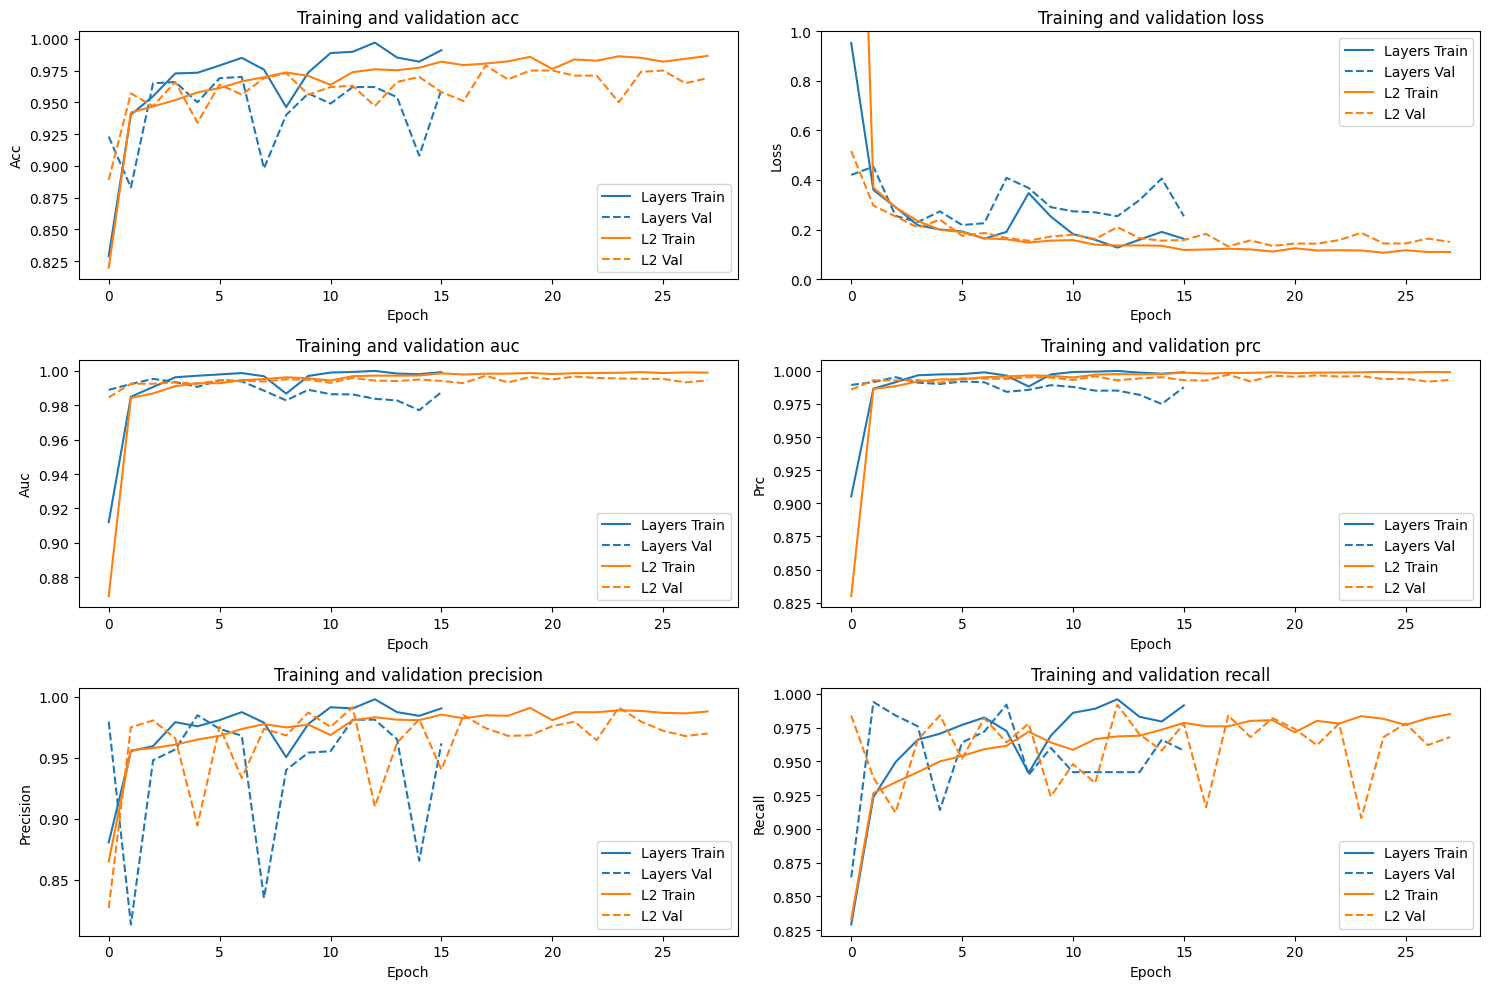

In [40]:
plot_metrics(layers_history, l2_history, legend1='Layers Train', legend2='Layers Val', legend3='L2 Train', legend4='L2 Val')

The metrics of both multilayered and `l2_model` performed pretty comparably. However, the differences between the loss metric is slightly higher for the multilayered model.

## Save the best fit model
The parameters of the model is observed and stored for future use. For this particular dataset, the `l2_model` yielded the best results.

In [41]:
l2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1032256)           0         
                                                                 
 dense_4 (Dense)             (None, 64)                66064448  
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 66,066,305
Trainable params: 66,066,305
Non-trainable params: 0
__________________________________________

In [42]:
l2_model.save('normal_pneumonia_with_augmented_data.keras')

## Using Vgg16 model to predict viral or bacterial pneumonia.
Because the data also labels whether the pneumonia is viral or bacterial, we can maybe create a model that separates the two. Instead of creating a new model, we can use the Vgg16 model to predict the etiology of pneumonia. The layers of the Vgg16 model can be seen here: 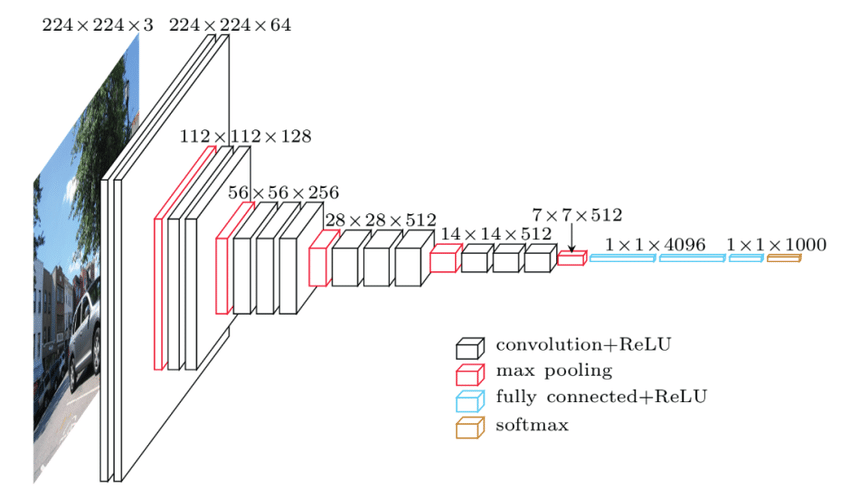
<br>The last layer will be changed to a dense layer with 1 output instead of 1000 because our outputs are binary. The preparation and results of the Vgg16 model is written [here](./Using%20the%20Vgg16%20model%20to%20separate%20pneumonia%20caused%20by%20virus%20and%20bacteria.ipynb).

### Summary of the new Vgg16 model

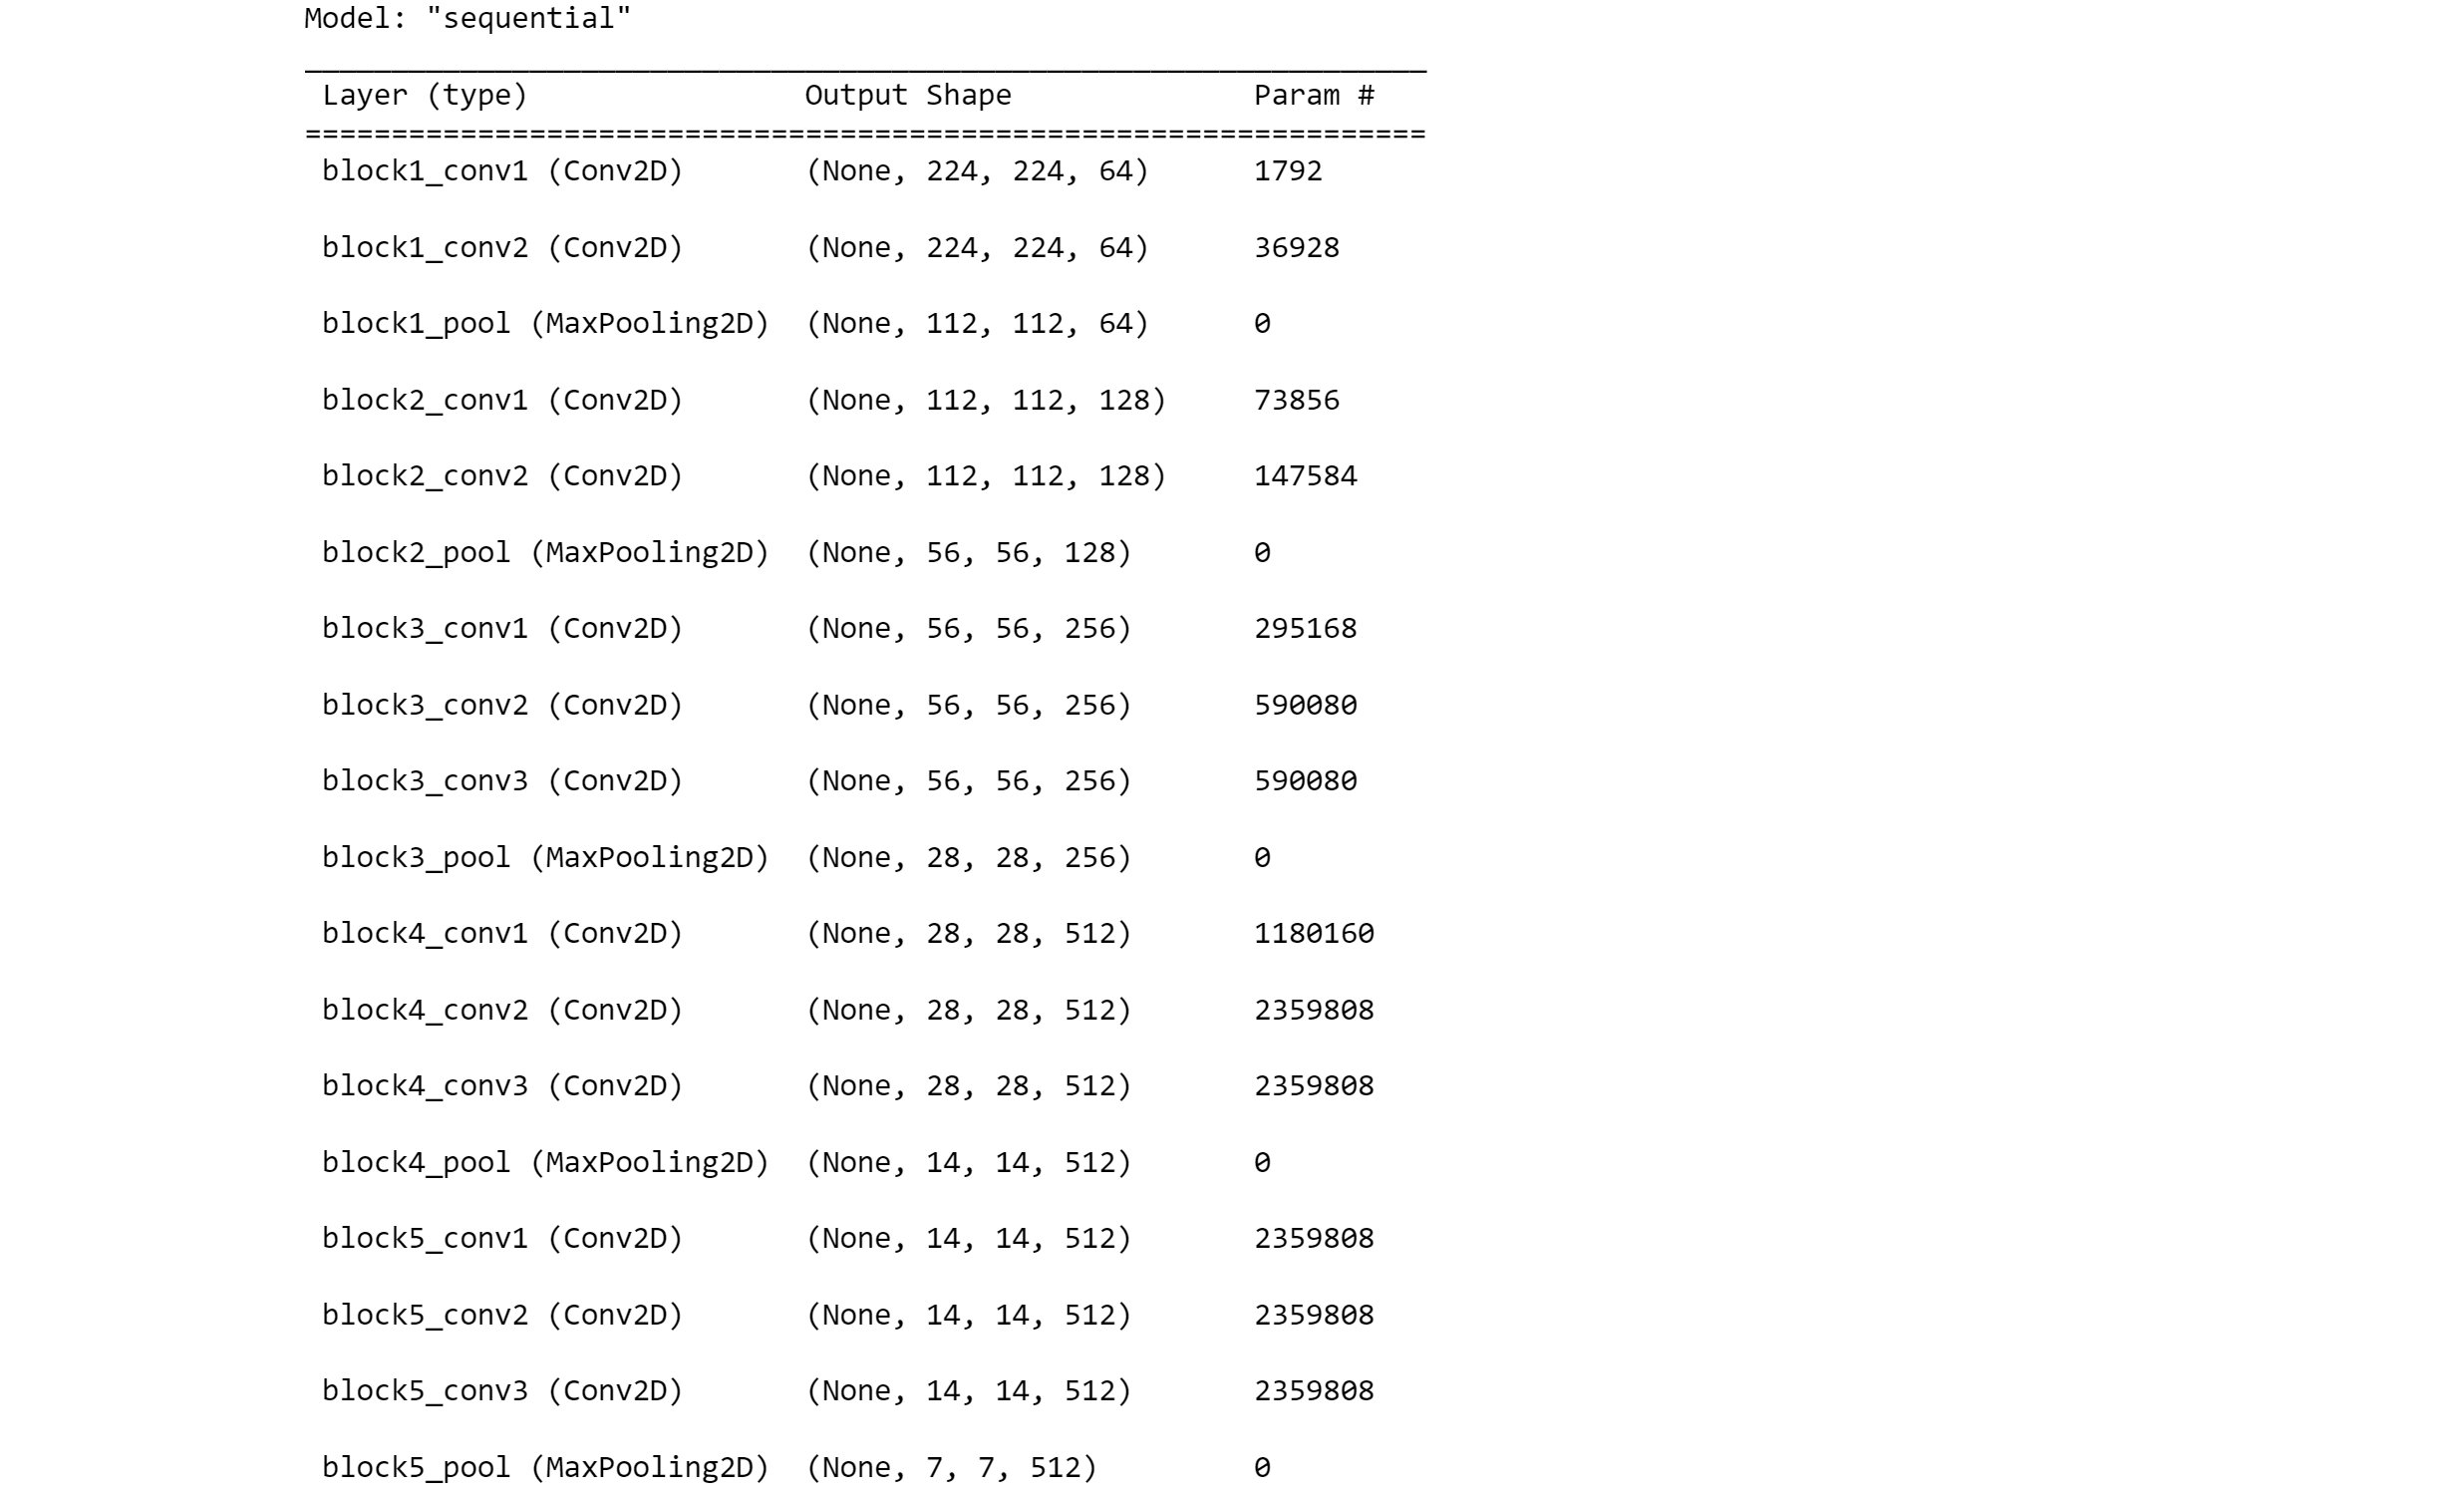
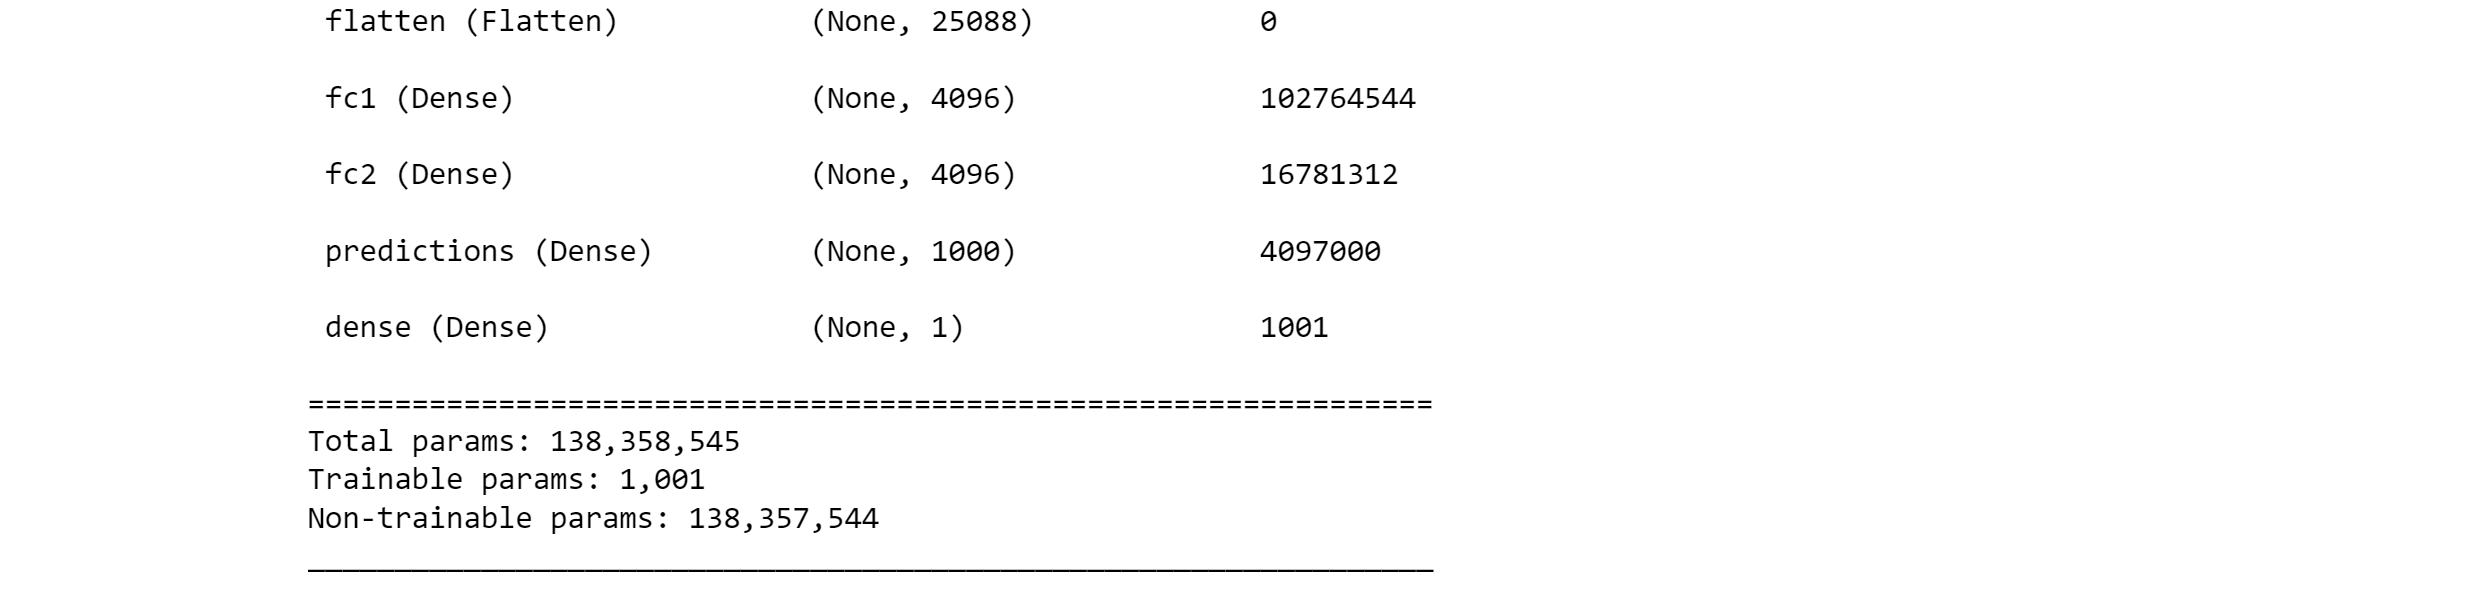

### Results of the Vgg16 model
| Metric| Value |
|:-----------------|:------:|
| Precision | 0.6012658227848101   |
| Recall    | 0.6418918918918919    |
| Accuracy  | 0.7025641025641025    |
| F1 Score  | 0.6209150326797386    |

## Conclusion
___
#### Recommendation
When integrating a ridge regression into our model, the `l2_model` is able to differentiate between patients with or without pneumonia decently. It has an accuracy score of around 81% while having a higher recall than precision score. This is preferred as we do not want to misdiagnose a patient who has pneumonia as being healthy. The `cnn_model` did return higher metrics than the `l2_model`, but the `cnn_model` experienced some overfitting. Therefore, it may not perform as well on a different test set and is omitted. These percentages may change as the code is rerun, but the recall seems to be consistently higher than the precision. We recommend the `l2_model` when predicting pneumonia from chest x-rays as it does a good job fitting the validation set while keeping accuracy and recall score relatively high. Further improvements to the model can be made but l2 regularizers should be implemented in `Dense()` layers.
#### Vgg16 model cannot tell the difference between viral and bacterial pneumonia
However, when trying to differentiate between viral and bacterial pneumonia, the model did not perform very well. This may be due to the images of the two classes being too similar. Perhaps with the inclusion of other symtoms, the model may return more accurate metrics. It could also be that the Vgg16 model is not very good at classifying these specific data and a new model should be constructed.
#### An issue with class imbalances
One major problem that we face in this project is the class imbalance issue. In an effort to preserve as much data as we can, we have created new images that are augmented from pre-existing images. This may be the reason why the recall score is higher than the precision. A better method may be just to undersample the majority class and apply an augmentation to the images in both classes.
#### Using AI to address issues in healthcare
According to [this article by the AHRQ](https://www.ahrq.gov/prevention/clinician/ahrq-works/burnout/index.html), around 50% of physicians experience burnout; with the ongoing shortage of doctors, this problem will only get worse. By applying the deep learning models in their healthcare programs, it may lessen the load on doctors and reduce burnout. In turn, more patients can be treated while improving patient-doctor dynamics.